In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [36]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [41]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
print(f"The most recent date in the data set is {most_recent_date}.")


The most recent date in the data set is 2017-08-23 00:00:00.


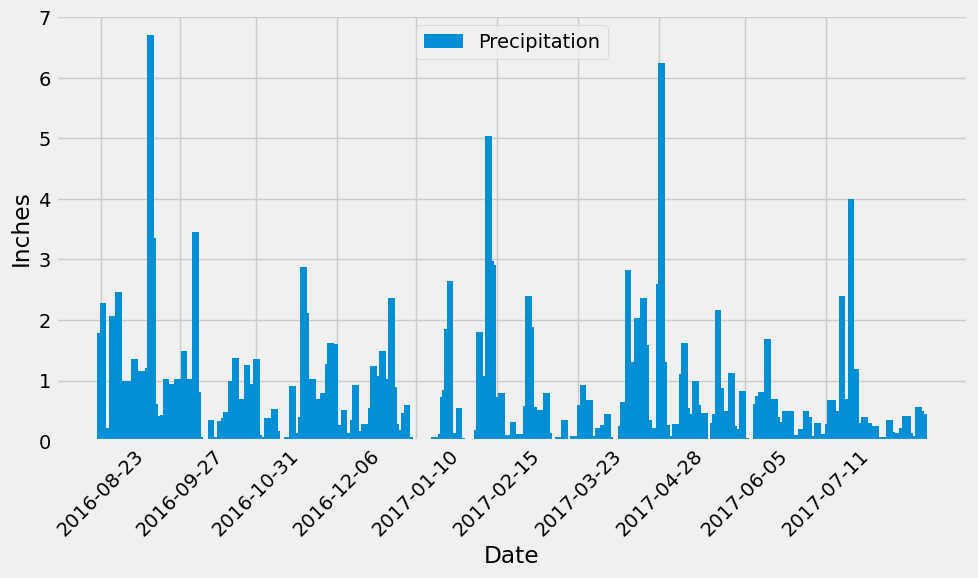

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in the data set
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
one_year_ago = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame with explicit column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

num_dates_to_display = 10
dates_to_display = precipitation_df['Date'][::len(precipitation_df) // num_dates_to_display]

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation', width=3)
plt.xlabel("Date")
plt.ylabel("Inches")


# Set x-axis ticks to the selected dates
plt.xticks(dates_to_display, rotation=45)

plt.legend(loc="upper center")
plt.tight_layout()
plt.show()



In [43]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()
summary_stats_df = pd.DataFrame(summary_stats)
summary_stats_df = summary_stats_df.rename(columns={'Precipitation': 'Precipitation Summary Statistics'})
summary_stats_df

,Precipitation Summary Statistics
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [44]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(Station.station).count()
print(f"There are {num_stations} stations in the dataset.")


There are 9 stations in the dataset.


In [45]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

station_activity_df = pd.DataFrame(station_activity, columns=['Station', 'Activity Count'])
station_activity_df



,Station,Activity Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [51]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
from sqlalchemy import func

# Find the most active station
most_active_station = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .first()[0]

# Calculate the lowest, highest, and average temperature for the most active station
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .all()

# Extract the results
lowest_temp = results[0][0]
highest_temp = results[0][1]
average_temp = results[0][2]

# Print the results
print(f"Most Active Station ID: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {average_temp:.2f}°F")




Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


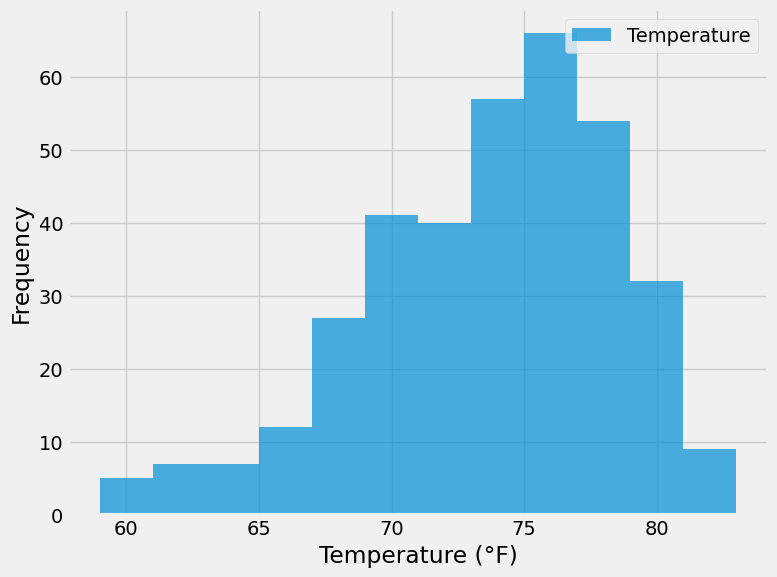

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the most recent date for the most active station
most_recent_date_active_station = session.query(Measurement.date)\
    .filter(Measurement.station == most_active_station)\
    .order_by(Measurement.date.desc())\
    .first()[0]

# Calculate the date one year from the most recent date for the most active station
one_year_ago_active_station = (dt.datetime.strptime(most_recent_date_active_station, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Query the temperature observations for the last 12 months for the most active station
temperature_data_active_station = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station, Measurement.date >= one_year_ago_active_station)\
    .all()

# Save the query results as a Pandas DataFrame
temperature_df_active_station = pd.DataFrame(temperature_data_active_station, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df_active_station['Temperature'], bins=12, label='Temperature', alpha=0.7)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()



# Close Session

In [48]:
# Close Session
session.close()